In [2]:

import zipfile


In [22]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

## Import Data

In [1]:
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [1]:
! which wget


wget not found


In [3]:
with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')

NameError: name 'zipfile' is not defined

In [30]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

## Clean Data and Filter For Needed Info

In [31]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [32]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
0,138860,110,245000,08/21/2014
4,213043,120,560000,12/20/2019
5,951120,900,85000,04/20/1989
7,122209,9002,5755000,04/25/2001
8,122209,9001,5755000,04/25/2001


In [33]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'SqFtLot', 'WfntLocation', 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616089 entries, 0 to 616088
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616089 non-null  int64 
 1   Minor           616089 non-null  int64 
 2   SqFtLot         616089 non-null  int64 
 3   WfntLocation    616089 non-null  int64 
 4   TrafficNoise    616089 non-null  int64 
 5   AirportNoise    616089 non-null  int64 
 6   PowerLines      616089 non-null  object
 7   OtherNuisances  616089 non-null  object
dtypes: int64(6), object(2)
memory usage: 37.6+ MB


In [34]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [35]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [36]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


In [37]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = real_property_sales.merge(parcel).merge(residential_building).drop_duplicates()
# Change dates to date time format
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [38]:
#Keeping only the most recent Sale_Price
buildings_df = merged_tables.sort_values('DocumentDate').drop_duplicates(['Major', 'Minor'],keep='first')

In [39]:
df_test = buildings_df.sort_values('DocumentDate')
df_test

,Major,Minor,SalePrice,DocumentDate,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrLivingUnits,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,Has_Porch
705940,514510,250,125000,1934-11-11,7041,0,0,0,N,N,1,910,0,0,0
443490,718680,30,600,1954-03-11,9345,0,0,0,N,N,1,1380,40,0,1
653999,245840,30,9500,1955-04-15,6300,0,1,0,N,N,1,820,0,0,0
962419,222470,151,12250,1959-10-10,11115,0,1,0,N,N,1,2090,0,0,0
235295,503180,251,2300,1960-09-27,19064,3,0,0,N,N,1,1140,40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900477,241990,45,642000,2020-09-08,11054,0,0,0,N,N,1,1510,0,0,0
366504,327530,150,393000,2020-09-09,9500,0,0,0,N,N,1,1250,110,0,1
925600,797260,2865,590000,2020-09-09,10275,0,0,0,N,N,1,1660,40,0,1
960304,330070,280,535000,2020-09-09,4000,0,0,0,N,N,1,700,0,0,0


In [77]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

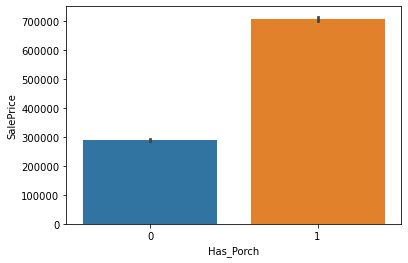

In [14]:
sns.barplot(df['Has_Porch'], df['SalePrice']);




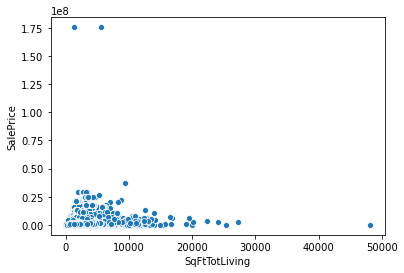

In [15]:
sns.scatterplot(df['SqFtTotLiving'], df['SalePrice']);




In [45]:
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.head()

,Unnamed: 0,Major,Minor,PropType,SqFtLot,SalePrice,DocumentDate,NbrLivingUnits,SqFtTotLiving,Has_Porch,Nuisances,WaterFrontLocation,Is_WaterFrontLocation,Has_Nuisance
0,0,807841,410,R,7424,847888,2019-08-16,1,2200,0,No Nuisances,None,0,0
1,1,755080,15,R,5000,819000,2019-10-12,1,1800,1,No Nuisances,None,0,0
2,2,229670,160,R,9853,730000,2019-07-21,1,2410,1,No Nuisances,None,0,0
3,3,513763,80,R,5239,612000,2019-03-01,1,2798,1,No Nuisances,None,0,0
4,4,868230,1740,R,4878,622000,2019-07-30,1,1510,1,No Nuisances,None,0,0


In [ ]:
#df.hist(figsize=(18,15), bins='auto');

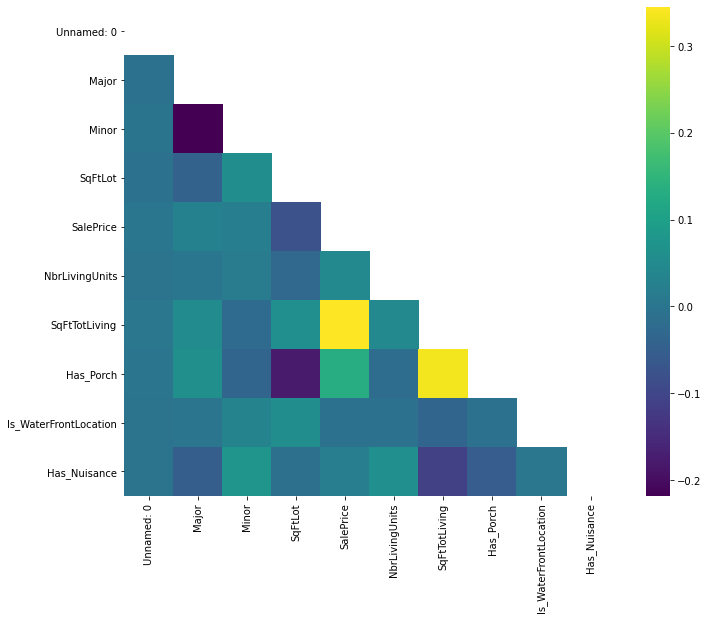

In [47]:
corr = df.corr()
# The mask is not necessary, but corr() has duplicate values on either side of the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

## EDA simple models


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline




In [55]:
# Define the problem
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch', 'Is_WaterFrontLocation','Has_Nuisance', 'SqFtLot']





In [47]:
# preprocessing
#for col in x_cols:
    #df[col] = (df[col] - df[col].mean())/df[col].std()
#df.head()





In [56]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()





<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     447.3
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:13:56   Log-Likelihood:            -1.9994e+05
No. Observations:               14744   AIC:                         3.999e+05
Df Residuals:                   14738   BIC:                         3.999e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.263e+05   6622.133     79.482      0.000    5.13e+05    5.39e+05
SqFtTotLiving            97.2756      2.244     43.342      0.000      92.876     101.675
Has_Porch              -343.2874   3382.052     -0.102      0.919   -6972.533    6285.958
Is_WaterFrontLocation   4.64e+04   2.66e+04      1.741      0.082   -5839.686    9.86e+04
Has_Nuisance           3.146e+04   4401.275      7.147      0.000    2.28e+04    4.01e+04
SqFtLot                  -8.0825      0.655    -12.345      0.000      -9.366      -6.799
==============================================================================
Omnibus:                      947.305   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.492
Skew:                           0.473   Prob(JB):                    2.67e-166
Kurtosis:                       2.412   Cond. No.                     1.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multicollinearity check

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [58]:
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('SqFtTotLiving', 7.609019989280393),
 ('Has_Porch', 2.597104948821414),
 ('Is_WaterFrontLocation', 1.0087467258201663),
 ('Has_Nuisance', 1.1481110431387374),
 ('SqFtLot', 5.581374479036737)]

In [ ]:
#values are under 5 vif, no collinearity as is

In [59]:
#testing with Rainbow test

rainbow_statistic, rainbow_p_value = linear_rainbow(fsm_model)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9924849849530865
Rainbow p-value: 0.6269421391554926


# Normality Check/Q-Q plot


In [60]:
import statsmodels.api as sm
import scipy.stats as stats

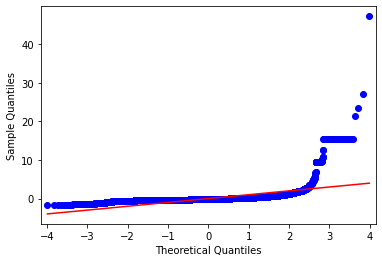

In [61]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='s', fit=True)

# Homoscedasticity Check

ValueError: x and y must be the same size

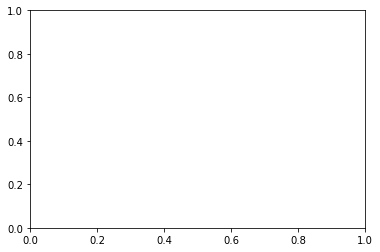

In [62]:
plt.scatter(model.predict(df[x_cols]), model.resid)
plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))]);